In [1]:
#script may throw some warning from Panda about writing to dataframes. This is because Pandas very cautiously warns you any
#time you ever write to a copy of a dataframe, even if you then store it somewhere, since many of its operations on slices
#are not "in-place" or may not act as they are expected to for experienced numpy users


import os
os.getcwd()

#script incorporates fix on our side for frettraj issue so frettraj doesnt need to be edited


import warnings
warnings.filterwarnings('ignore')

In [2]:
import yaml

# Specify the path to your YAML file
yaml_file_path = "./config.yaml"

# Load the YAML file
with open(yaml_file_path, "r") as yaml_file:
    settings = yaml.safe_load(yaml_file)

# Now, the 'settings' variable contains the loaded YAML data


In [3]:
if settings['exclude_residues']:
    for i in settings['excluded_residues']:
        if type(i)==int:
            continue
        if type(i)==list:
            settings['excluded_residues'].remove(i)
            settings['excluded_residues'].extend(list(range(i[0],i[1]+1)))
        else:
            raise Exception('Invalid index encountered in exclusion list.')
    settings['excluded_residues'].sort()

In [4]:
if settings['Save_AVs_pkl']==True or settings['Save_AVs_xyz']==True:
    avfoldername='AVs_{0}'.format(settings['Considered_Atoms'])
    if settings['Considered_Atoms']=='Local_Labeled_Only':
        avfoldername=avfoldername+'_'+str(settings['Residues_Range_to_Ignore'])+'_residue_window'
    try:
        os.mkdir(settings['output_directory']+avfoldername)
    except FileExistsError:
        print('AVs Directory exists')
    except:
        print('Something went wrong.')

AVs Directory exists


In [5]:
#%% Import statements

#import subprocess       #used for running bash within Python
import numpy as np      #used for various math functions as well as arrays
import math as m        #math functions
import pandas as pd     #structure output files into useful formats
import matplotlib.pyplot as plt #used for output plots
from matplotlib.colors import LogNorm #useful normalization for many plots' colorscaling
import matplotlib.colors as mcolor
from itertools import combinations #used for generating pairwise combinations of objects, especially residues
#import multiprocessing as mup #for future implementation of parallelization
import json             #used for handling options files for AV sims. Will likely convert these to pandas objects

import mdtraj as md     #used for loading and working with structure files. Alternative packages, with some reworking, would include Bio.PDB
#import avtraj as av     #used for generating accessible volume simulations of fluorophores. However, gives warnings with numba
import fretraj as ft    #alternative used for generating accessible volume simulations of fluorophores. Can also simulate photon traces
import copy
import warnings
import random
random.seed(settings['Randomization Seed'])

from Script_Dependancies import GenerateMSA as msa


os.chdir(settings['dependancy_directory']) #folder containing the scripts needed for this to run
import DCA              #used for direct coupling analysis (DCA), a co-evolution approach to parsing out mutual information between residues that hints at interactions
import ConservationScore #used for single residue conservation score analysis with simple shannon entropy. can add other function options as well



In [6]:

print("fretraj: "+ ft.__version__)
print("mdtraj: "+ ft.__version__)
print("numpy: " + np.__version__)
import numba as nb
print("numba: " + nb.__version__)
import matplotlib as mpl
print("matplotlib: " + mpl.__version__)
import sys
print("python: " + sys.version)
print("pandas: " + pd.__version__)
# print("mdtraj: " + md.__version__)
print("json: " + json.__version__)

fretraj: 0.2.10
mdtraj: 0.2.10
numpy: 1.24.4
numba: 0.58.1
matplotlib: 3.7.4
python: 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38) 
[GCC 7.3.0]
pandas: 2.0.3
json: 2.0.9


In [7]:
def gaussian(x,u,s,mode='normal'):
    if mode=='normal':
        return np.exp(-.5*((x-u)/s)**2.)*(2*s**2.*np.pi)**(-.5)
    if mode=='peakto1':
        return np.exp(-.5*((x-u)/s)**2.)

In [8]:
"""Add multi-chain support"""


'Add multi-chain support'

In [9]:
#adjust figure output parameters for figures made in matplotlib
import matplotlib.pylab as pylab 
pylab.rcParams.update(settings['figure_parameters'])

In [10]:
#change to or add input directory
try:
    os.chdir(settings['input_directory'])
except FileNotFoundError:
    os.mkdir(settings['input_directory'])
    os.chdir(settings['input_directory'])

In [11]:
#Pandas DataFrame will contain all single-residue information for each lookup
single_residue_info=pd.DataFrame()
#load the input structures
md_struct=md.load(settings['input_structures'])

In [12]:
#set up initial single-residue information


#grab residue list from structure. Maintains residue object types
single_residue_info['Residue List']=md_struct.topology._residues
#residue indices
single_residue_info['Residue Index']=[x.resSeq for x in single_residue_info['Residue List']]
#Residue 1 letter codes
single_residue_info['One Letter Code']=[x for x in md_struct.topology.to_fasta()[0]]
#Residue label atom Serial ID
single_residue_info['{0} Serial ID'.format(settings['AV_label_atom'])]=[md_struct[0].top._atoms[i].serial for i in md_struct[0].top.select("name {0}".format(settings['AV_label_atom']))]
#Residue non-serial id (index); a unique identified that doesn't change as atoms are deleted
single_residue_info['{0} Index ID'.format(settings['AV_label_atom'])]=[md_struct[0].top._atoms[i].index for i in md_struct[0].top.select("name {0}".format(settings['AV_label_atom']))]
#list of residues "good"=True or "bad"=False. Residues converted to bad when some undesirable quality is found at the single residue level
single_residue_info['Good List']=[True for res in range(len(single_residue_info['Residue List']))]
print('#Good={0}'.format(sum(single_residue_info['Good List'])))
#remove residues we specified for removal
if settings['exclude_residues']:
    single_residue_info.loc[[x in settings['excluded_residues'] for x in single_residue_info['Residue Index']],'Good List']=False
    print('#Good={0}'.format(sum(single_residue_info['Good List'])))
if settings['define_domains']:
    for i in range(len(single_residue_info)):
        if not any([single_residue_info['Residue Index'][i] in x for x in [list(range(y[1],y[2]+1)) for y in settings['domain_bounds']]]):
            single_residue_info['Good List'][i]=False
    print('#Good={0}'.format(sum(single_residue_info['Good List'])))
#define the index of the first residue as a reference for those outputs that index at 0 or 1
first_residue=int(str(list(md_struct.topology.residues)[0])[3:])

#Good=271
#Good=271


In [13]:
single_residue_info

,Residue List,Residue Index,One Letter Code,CA Serial ID,CA Index ID,Good List
0,LYS1,1,K,3,2,True
1,ASP2,2,D,13,12,True
2,THR3,3,T,22,21,True
3,ILE4,4,I,30,29,True
4,ALA5,5,A,39,38,True
...,...,...,...,...,...,...
266,LEU267,267,L,2221,2220,True
267,VAL268,268,V,2230,2229,True
268,VAL269,269,V,2238,2237,True
269,LYS270,270,K,2246,2245,True


In [14]:
#create initial dataframe containing residue pair-pair information

#Pandas DataFrame will contain all pair-wise residue information for each pair. 
#length Nx(N-1)/2 (no need to compute self-pair parameters/diagonal of matrix nor degenrate pairs (ie 1-5, 5-1)). 
#Data per column is 1D, should be squareformed for plotting
pair_residue_info=pd.DataFrame()
pair_residue_info['Residue Pair']=list(combinations(single_residue_info['Residue Index'],2)) #given as tuples with indexing as in single_residue_info (original indexing)
pair_residue_info['Good List']=[True for i in range(len(pair_residue_info))]
#make sure pairs span domains. so first, create list of all valid pairs
explicitdomains=[list(range(y[1], y[2]+1)) for y in settings['domain_bounds']]
for j in range(len(explicitdomains)):
    for i in settings['excluded_residues']:
        if i in explicitdomains[j]:
            explicitdomains[j].remove(i)
if settings['define_domains']:        
    domaincombos=combinations(list(range(len(settings['domain_bounds']))),2)
    valid_pairs=[]
    for i in domaincombos:
        valid_pairs.extend([(x,y) for x in explicitdomains[i[0]] for y in explicitdomains[i[1]]])
    for i in range(len(pair_residue_info)):
        if pair_residue_info['Residue Pair'][i] not in valid_pairs:
            pair_residue_info['Good List'][i]=False
print('#Good pairs={0}'.format(sum(pair_residue_info['Good List'])))

#Good pairs=16932


In [15]:
pair_residue_info

,Residue Pair,Good List
0,"(1, 2)",False
1,"(1, 3)",False
2,"(1, 4)",False
3,"(1, 5)",False
4,"(1, 6)",False
...,...,...
36580,"(268, 270)",False
36581,"(268, 271)",False
36582,"(269, 270)",False
36583,"(269, 271)",False


In [16]:
#directory for outputs

try:
    os.chdir(settings['output_directory'])
except FileNotFoundError:
    os.mkdir(settings['output_directory'])
    os.chdir(settings['output_directory'])

In [17]:
#generate a text fasta file for input to external MSA script (header is also added to the file)
with open('Input_Structure_FASTA.fasta','w+') as f:
    f.write('>Input_Structure\n'+md_str.topology.to_fasta()[0]+'\n')
    f.close()
    


In [18]:
#auto generate MSA alignment file when requested
os.chdir(settings['repo_abs_path'])

if  settings['generate_MSA'] == True:
    msa.generate_msa(settings)

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             Input_Structure_FASTA.fasta
# output HMM file:                  OutHMM.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Input_Structure_FASTA     1   271   271     0.41  0.587 

# CPU time: 0.42u 0.00s 00:00:00.42 Elapsed: 00:00:00.44



Error: Failed to open sequence file /zfs/smblab/group_software/HMMER/Pfam-A.fasta.gz for reading




Original number of sequences: 22791


Number(%) of sequences excluded: 15142 (66.44%)


File saved as: OutMSA.msa_filtered30


In [19]:
#while its called inDCA, this is the MSA file used for both DCA and single residue conservation
#pregenerated should be made via Aish's get_alignments.bash until Frank's implementation is here

if settings['generate_MSA'] == True:
    inDCA=settings['outputMSA_filename']+'_filtered{0}'.format(settings['max_align_gaps'])
else:
    inDCA=settings['pregenerated_MSA_file']
    
    

In [20]:
#perform DCA using the generated multi sequence alignment
#counterbalance to single residue conservation, as indicates variability in residue position may be dependent on another co-substitution
if not settings['pregenerated_DCA']:    
    outDCA=settings['DCA_output']
    DCA.dca(inDCA,outDCA, theta=0.1)
else:
    outDCA=settings['pregenerated_DCA_file']
DCAresult=np.loadtxt(outDCA)
pair_residue_info['DCA Mutual Info']=DCAresult[:,2]
pair_residue_info['DCA Direct Info']=DCAresult[:,3]
del(DCAresult)

In [21]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info
0,"(1, 2)",False,0.000000,0.053536
1,"(1, 3)",False,0.000000,0.028687
2,"(1, 4)",False,0.000000,0.013261
3,"(1, 5)",False,0.000000,0.005106
4,"(1, 6)",False,0.000000,0.003006
...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440
36581,"(268, 271)",False,0.002085,0.032441
36582,"(269, 270)",False,0.012332,0.083140
36583,"(269, 271)",False,0.002435,0.045029


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

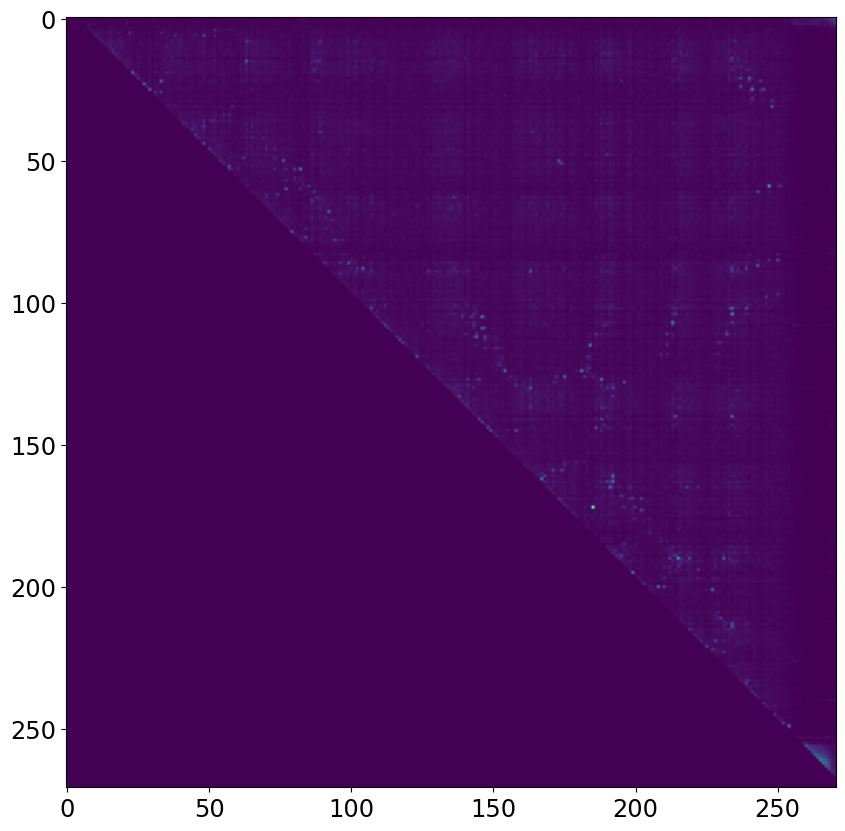

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

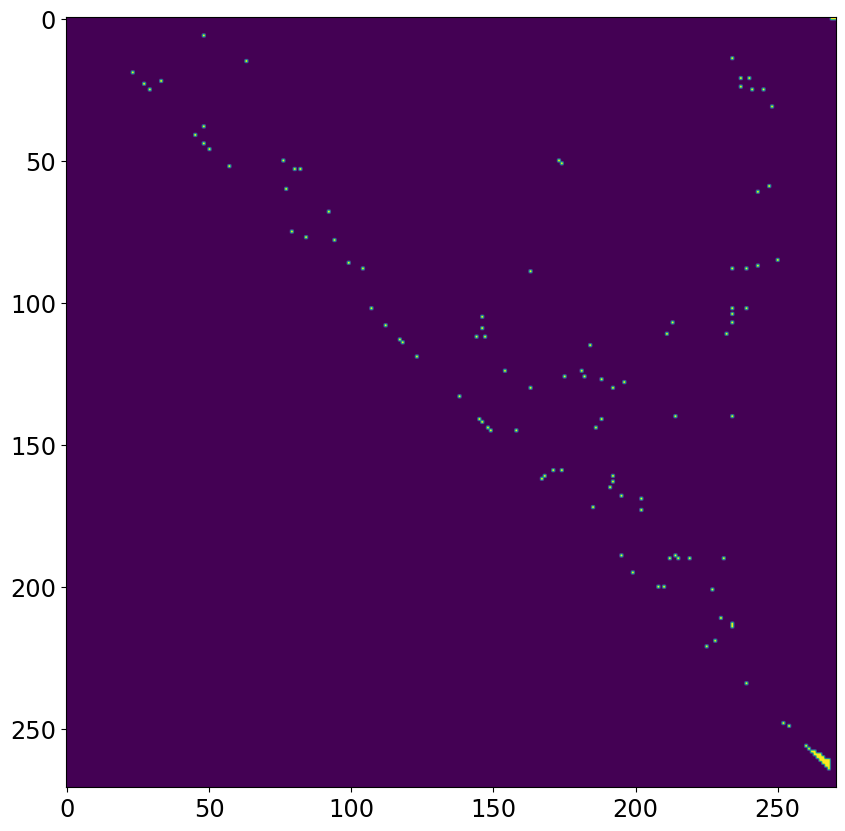

In [22]:
#visualize DCA. Threshold here not applied in analysis, ony visualization. For analysis, DI values are instead ranked

to_im=np.zeros((len(single_residue_info),len(single_residue_info)))
to_im_thresh=np.zeros((len(single_residue_info),len(single_residue_info)))
vis_thresh=0.05
min_dist=3
for i in range(len(pair_residue_info)):
    if abs(pair_residue_info['Residue Pair'][i][0]-pair_residue_info['Residue Pair'][i][1])>min_dist:
        to_im[pair_residue_info['Residue Pair'][i][0]-1,pair_residue_info['Residue Pair'][i][1]-1]=pair_residue_info['DCA Direct Info'][i]
        if pair_residue_info['DCA Direct Info'][i]>vis_thresh:
            to_im_thresh[pair_residue_info['Residue Pair'][i][0]-1,pair_residue_info['Residue Pair'][i][1]-1]=1
plt.imshow(to_im, vmin=pair_residue_info['DCA Direct Info'].min())
plt.show()
plt.imshow(to_im_thresh)
plt.show()

In [23]:
#single residue conservation scoring
#uses simple Shannon entropy metric for the information associated with each residue position
#high information content makes labeling favorable, as the position naturally experiences heterogeneity, so substitutions are favorable
#output file name
settings['output_conservation_score_file']='OutConScore.dat'
#alphabet of supported characters/residues for conservation score analysis. for now, is just native protein AAs+placeholder characters
settings['conservation_alphabet']=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

#converts the sequence-wise array to a column-wise list to fead to conservation scorer
columnwise=[col for col in np.array([[res for res in seq] for seq in np.loadtxt(inDCA,dtype='str',usecols=0)[1::2]]).T]

#function takes a single string of characters and computes shannon entropy, so have to feed it columns from MSA.
#computes entropy weighted by the equally-weighted probability of all alphabet entries (1./22. for 22 entries)
ConScores=[ConservationScore.ConservationScore(col,settings['conservation_alphabet'],weight=1.,logbase=m.e) for col in columnwise]
single_residue_info['Conservation Scores']=ConScores

In [24]:
single_residue_info

,Residue List,Residue Index,One Letter Code,CA Serial ID,CA Index ID,Good List,Conservation Scores
0,LYS1,1,K,3,2,True,0.000000
1,ASP2,2,D,13,12,True,-0.078261
2,THR3,3,T,22,21,True,-0.172994
3,ILE4,4,I,30,29,True,-0.716431
4,ALA5,5,A,39,38,True,-1.119702
...,...,...,...,...,...,...,...
266,LEU267,267,L,2221,2220,True,-0.040840
267,VAL268,268,V,2230,2229,True,-0.038046
268,VAL269,269,V,2238,2237,True,-0.026204
269,LYS270,270,K,2246,2245,True,-0.011034


In [25]:
#calculate inter-residue contacts (distances). Used to threshold sites to remove those that make contacts with each other
contacts,contactsindices=md.compute_contacts(md_struct)
maxadder=np.ones((len(contacts),1))*np.max(contacts)
contacts=np.concatenate((maxadder,maxadder,contacts),axis=1)
contactsindices=np.concatenate((np.array([[0,1],[0,2]]),contactsindices))
for i in range(len(pair_residue_info)-4):
    if contactsindices[i][0]<contactsindices[i+1][0] and contactsindices[i][0]<len(single_residue_info)-1:
        contacts=np.concatenate((contacts[:,i+1:],maxadder,maxadder,contacts[:,:i+1]),axis=1)
        contactsindices=np.vstack((contactsindices[:i+1], np.array([[contactsindices[i][0]+1,contactsindices[i][0]+2],[contactsindices[i][0]+1,contactsindices[i][0]+3]]),contactsindices[i+1:]))
contacts=np.concatenate((contacts,maxadder,maxadder,maxadder),axis=1)
contactsindices=np.vstack((contactsindices, np.array([[contactsindices[-1][0]+1,contactsindices[-1][1]-1],[contactsindices[-1][0]+1,contactsindices[-1][1]],[contactsindices[-1][0]+2,contactsindices[-1][1]]])))

la=0
for i in settings['input_structures']:
    pair_residue_info['Contacts '+i+' (nm)']=contacts[la]
    la+=1
del(la)
pair_residue_info['Contacts']=[i for i in contacts.T]
pair_residue_info['Mean Contacts']=np.mean(contacts,axis=0)

In [26]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",3.840744
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",4.036261
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",3.905426
...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",3.370560
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",3.527306
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748


In [27]:
#compute solvent-accessible surface area for all residues in all frames
#is a measure of accessibility for labeling
SASA=md.shrake_rupley(md_struct,mode='residue')
la=0
for i in settings['input_structures']:
    single_residue_info['SASA ' + i + ' (nm^2)']=SASA[la]
    la+=1
single_residue_info['Mean SASA (nm^2)']=np.mean(SASA,axis=0)
del(la)
del(SASA)

In [28]:
single_residue_info

,Residue List,Residue Index,One Letter Code,CA Serial ID,CA Index ID,Good List,Conservation Scores,SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm^2),SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm^2),SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm^2),Mean SASA (nm^2)
0,LYS1,1,K,3,2,True,0.000000,1.883567,1.840754,1.717470,1.813931
1,ASP2,2,D,13,12,True,-0.078261,0.458902,0.689405,0.654234,0.600847
2,THR3,3,T,22,21,True,-0.172994,0.172812,0.411882,0.281994,0.288896
3,ILE4,4,I,30,29,True,-0.716431,0.016353,0.026437,0.003807,0.015533
4,ALA5,5,A,39,38,True,-1.119702,0.002374,0.000003,0.002516,0.001631
...,...,...,...,...,...,...,...,...,...,...,...
266,LEU267,267,L,2221,2220,True,-0.040840,0.736000,0.722796,0.685367,0.714721
267,VAL268,268,V,2230,2229,True,-0.038046,0.137116,0.432906,0.062184,0.210735
268,VAL269,269,V,2238,2237,True,-0.026204,0.535588,0.593804,0.477998,0.535797
269,LYS270,270,K,2246,2245,True,-0.011034,0.850658,0.767130,1.719868,1.112552


In [33]:
#generate the dye parameter file required by frettraj from the settings corresponding to fluorophores in the settings section.
#will be modified as structure is modified if anything but "all" was selected for the av considered atoms mode

if settings['generate_dye_parameters_file']==True:
    Dye_Params={'Position':{}}
    Dye_Params['Distance']=settings['basic_dye_parameters']['Distance']
    for i in range(len(single_residue_info)):
        for j in settings['basic_dye_parameters']['Position']:
            Dye_Params['Position']['{0}_'.format(single_residue_info['Residue List'][i])+j]=copy.copy(settings['basic_dye_parameters']['Position'][j])
            Dye_Params['Position']['{0}_'.format(single_residue_info['Residue List'][i])+j]['attach_id']=int(single_residue_info['{0} Serial ID'.format(settings['AV_label_atom'])][i])
    json_file=json.dumps(Dye_Params)
    with open("Dye_Params.json", "w") as outfile:
        outfile.write(json_file)
    Dye_Params_file='Dye_Params.json'
elif settings['generate_dye_parameters_file']=='Load':
    Dye_Params_file='Dye_Params.json'
    with open(Dye_Params_file, 'r') as f:
        Dye_Params=json.load(f)
elif settings['generate_dye_parameters_file']=='Specify':
    Dye_Params_file=settings['specified_dye_parameters_file']
    with open(Dye_Params_file, 'r') as f:
        Dye_Params=json.load(f)   

In [25]:

#generate AVs for all sites
#modifies the structure and labeling files based on considered_atoms if Do_AV is true to reduce steric clashes at the labeling sites
#can also load previous run AVs for the same structures for faster runs
#this version is the old behavior, where it relies on fixes implemented directly into frattraj's cloud.py file
#moving toward fixing on our end in this script, but keeping previous behavior on our end in case they fix frettraj

if settings['fretraj_fix_our_side']==False: 
    temp1=[] 
    temp2=[]
    Mod_Dye_Params_file='Mod_'+Dye_Params_file
    if settings['Do_AV']==True:
        mod_struct=copy.copy(md_struct) #generate a modified structure based on the desired considerations for av simulations


        if settings['Considered_Atoms']=='Global_Labeled_Only': #for these two, can do the modification ahead of time so we don't have to read/write so often
            #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
            with open(Dye_Params_file,'r') as f:
                Mod_Dye_Params=json.load(f)
            mod_struct=copy.copy(md_struct.atom_slice(np.where([i.name==settings['AV_label_atom'] for i in mod_struct.top.atoms])[0]))

            with open(Mod_Dye_Params_file, 'w') as f:
                f.write(json.dumps(Mod_Dye_Params))
            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)

        elif settings['Considered_Atoms']=='Backbone_Only':

            #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
            with open(Dye_Params_file,'r') as f:
                Mod_Dye_Params=json.load(f)

            mod_struct=copy.copy(md_struct.atom_slice(np.where([i.is_backbone for i in mod_struct.top.atoms])[0]))
            with open(Mod_Dye_Params_file, 'w') as f:
                f.write(json.dumps(Mod_Dye_Params))    

            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
        #for i in range(87,90):#
        for i in range(len(single_residue_info)):
            print(single_residue_info['Residue List'].iloc[i])
            if settings['Considered_Atoms']=='all':
                labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
                AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
                AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))
            elif settings['Considered_Atoms']=='Global_Labeled_Only' or settings['Considered_Atoms']=='Backbone_Only':
                AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
                AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))

            elif settings['Considered_Atoms']=='Local_Labeled_Only':
                #have to do the modifications on a per-residue basis here, so must reload mod_struct each time
                mod_struct=copy.copy(md_struct)
                #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices, and do so for each new residue
                with open(Dye_Params_file,'r') as f:
                    Mod_Dye_Params=json.load(f)
                tempresname=str(list(mod_struct.top.residues)[i])
                if i < settings['Residues_Range_to_Ignore']:
                    mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[0:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))
                else:
                    mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))

                with open(Mod_Dye_Params_file, 'w') as f:
                    f.write(json.dumps(Mod_Dye_Params))                 

                labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
                AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
                AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))

                del(tempresname)
            temp1.append(AVs1)
            temp2.append(AVs2)

            with warnings.catch_warnings(record=True):
                if settings['Save_AVs_pkl']==True:
                    os.chdir(settings['output_directory']+avfoldername)
                    try:
                        ft.cloud.save_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs1)
                    except:
                        print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    try:
                        ft.cloud.save_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs2)
                    except:
                        print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    os.chdir(settings['output_directory'])
                if settings['Save_AVs_xyz']==True:
                    os.chdir(settings['output_directory']+avfoldername)
                    try:
                        ft.cloud.save_acv_traj(r'AVs1_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs1, format='xyz')
                    except:
                        print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    try:
                        ft.cloud.save_acv_traj(r'AVs2_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs2, format='xyz')   
                    except:
                        print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    os.chdir(settings['output_directory'])
        # del(mod_struct)
    elif settings['Do_AV']=='Load':
        labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
        for i in range(len(single_residue_info)):
            os.chdir(settings['output_directory']+avfoldername)
            try:
                AVs1=ft.cloud.load_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]))
            except:
                print('AV1 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
                AVs1=None
            try:
                AVs2=ft.cloud.load_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]))
            except:
                print('AV2 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
                AVs2=None
            os.chdir(settings['output_directory'])
            temp1.append(AVs1)
            temp2.append(AVs2)

    single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_AVs']=temp1
    single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_AVs']=temp2
    del(temp1)
    del(temp2)



In [35]:

#generate AVs for all sites
#takes a bit and outputs a lot; can be silenced but isnt so correct atoms can be veridied for labeling

#generate AVs for all sites
#modifies the structure and labeling files based on considered_atoms if Do_AV is true to reduce steric clashes at the labeling sites
#can also load previous run AVs for the same structures for faster runs
#this version is the new behavior, where it relies on fixes implemented directly here rather than frettraj files
#moving toward fixing on our end in this script, but keeping previous behavior on our end in case they fix frettraj



if settings['fretraj_fix_our_side']==True:
    temp1=[] 
    temp2=[]
    Mod_Dye_Params_file='Mod_'+Dye_Params_file
    if settings['Do_AV']==True:
        mod_struct=copy.copy(md_struct) #generate a modified structure based on the desired considerations for av simulations


        if settings['Considered_Atoms']=='Global_Labeled_Only': #for these two, can do the modification ahead of time so we don't have to read/write so often
            #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
            with open(Dye_Params_file,'r') as f:
                Mod_Dye_Params=json.load(f)
            mod_struct=copy.copy(md_struct.atom_slice(np.where([i.name==settings['AV_label_atom'] for i in mod_struct.top.atoms])[0]))
            for j in keys:
                Mod_Dye_Params['Position'][j]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][j]['attach_id']][0]+1
            
            
            with open(Mod_Dye_Params_file, 'w') as f:
                f.write(json.dumps(Mod_Dye_Params))
            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)

        elif settings['Considered_Atoms']=='Backbone_Only':

            #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
            with open(Dye_Params_file,'r') as f:
                Mod_Dye_Params=json.load(f)

            mod_struct=copy.copy(md_struct.atom_slice(np.where([i.is_backbone for i in mod_struct.top.atoms])[0]))
            keys=list(Mod_Dye_Params['Position'].keys())
            for j in keys:
                Mod_Dye_Params['Position'][j]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][j]['attach_id']][0]+1
            
            with open(Mod_Dye_Params_file, 'w') as f:
                f.write(json.dumps(Mod_Dye_Params))    

            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
        #for i in range(87,90):#
        for i in range(len(single_residue_info)):
            print(single_residue_info['Residue List'].iloc[i])
            if settings['Considered_Atoms']=='all' or settings['Considered_Atoms']=='Global_Labeled_Only' or settings['Considered_Atoms']=='Backbone_Only':
                with open(Dye_Params_file,'r') as f:
                    Mod_Dye_Params=json.load(f)
                
                Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0]]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0]]['attach_id']][0]+1
                Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1]]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1]]['attach_id']][0]+1

                with open(Mod_Dye_Params_file, 'w') as f:
                    f.write(json.dumps(Mod_Dye_Params))  
                labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
                AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
                AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))
                
            elif settings['Considered_Atoms']=='Local_Labeled_Only':
                #have to do the modifications on a per-residue basis here, so must reload mod_struct each time
                mod_struct=copy.copy(md_struct)
                #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices, and do so for each new residue
                with open(Dye_Params_file,'r') as f:
                    Mod_Dye_Params=json.load(f)
                tempresname=str(list(mod_struct.top.residues)[i])
                if i < settings['Residues_Range_to_Ignore']:
                    mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[0:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))
                else:
                    mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))
                
                
                
                
                #Mod_Dye_Params['Position'][j]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][j]['attach_id']][0]+1
                Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0]]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0]]['attach_id']][0]+1
                Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1]]['attach_id']=[k.index for k in mod_struct.top.atoms if k.serial==Mod_Dye_Params['Position'][str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1]]['attach_id']][0]+1

                with open(Mod_Dye_Params_file, 'w') as f:
                    f.write(json.dumps(Mod_Dye_Params))                 

                labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
                AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
                AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))

                del(tempresname)
            temp1.append(AVs1)
            temp2.append(AVs2)

            with warnings.catch_warnings(record=True):
                if settings['Save_AVs_pkl']==True:
                    os.chdir(settings['output_directory']+avfoldername)
                    try:
                        ft.cloud.save_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs1)
                    except:
                        print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    try:
                        ft.cloud.save_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs2)
                    except:
                        print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    os.chdir(settings['output_directory'])
                if settings['Save_AVs_xyz']==True:
                    os.chdir(settings['output_directory']+avfoldername)
                    try:
                        ft.cloud.save_acv_traj(r'AVs1_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs1, format='xyz')
                    except:
                        print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    try:
                        ft.cloud.save_acv_traj(r'AVs2_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs2, format='xyz')   
                    except:
                        print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                    os.chdir(settings['output_directory'])
        # del(mod_struct)
    elif settings['Do_AV']=='Load':
        labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
        for i in range(len(single_residue_info)):
            os.chdir(settings['output_directory']+avfoldername)
            try:
                AVs1=ft.cloud.load_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]))
            except:
                print('AV1 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
                AVs1=None
            try:
                AVs2=ft.cloud.load_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]))
            except:
                print('AV2 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
                AVs2=None
            os.chdir(settings['output_directory'])
            temp1.append(AVs1)
            temp2.append(AVs2)

    single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_AVs']=temp1
    single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_AVs']=temp2
    del(temp1)
    del(temp2)


LYS1
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
ASP2
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
THR3
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
ILE4
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
ALA5
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
LEU6
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
VAL7
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
VAL8
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
SER9
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
THR10
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
LEU11
Pro

In [39]:
single_residue_info

,Residue List,Residue Index,One Letter Code,CA Serial ID,CA Index ID,Good List,Conservation Scores,SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm^2),SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm^2),SASA /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm^2),Mean SASA (nm^2),Al488C5_AVs,Al647C2_AVs,Al488C5_grid1dsum,Al647C2_grid1dsum,avg_Al488C5_grid1dsum,avg_Al647C2_grid1dsum
0,LYS1,1,K,3,2,True,0.000000,1.883567,1.840754,1.717470,1.813931,[<fretraj.cloud.Volume object at 0x152b4db168b...,[<fretraj.cloud.Volume object at 0x152b4ca00df...,"[20619.00000000028, 20613.66666666653, 19585.3...","[21041.00000000022, 21055.666666666875, 19977....",20272.666667,20691.444444
1,ASP2,2,D,13,12,True,-0.078261,0.458902,0.689405,0.654234,0.600847,[<fretraj.cloud.Volume object at 0x152b4c1361c...,[<fretraj.cloud.Volume object at 0x152b4750ccd...,"[16798.000000000604, 16816.666666667756, 16433...","[17025.66666666665, 17088.333333333867, 16679....",16682.777778,16931.222222
2,THR3,3,T,22,21,True,-0.172994,0.172812,0.411882,0.281994,0.288896,[<fretraj.cloud.Volume object at 0x152b474d79d...,[<fretraj.cloud.Volume object at 0x152b4c8d249...,"[11856.666666666719, 11816.666666667255, 11190...","[11925.666666666446, 11911.66666666679, 11293....",11621.333333,11710.222222
3,ILE4,4,I,30,29,True,-0.716431,0.016353,0.026437,0.003807,0.015533,[<fretraj.cloud.Volume object at 0x152b4c869fd...,[<fretraj.cloud.Volume object at 0x152b4d00c58...,"[3231.000000000025, 4919.333333333258, 5446.00...","[3258.999999999976, 4933.666666666615, 5525.00...",4532.111111,4572.555556
4,ALA5,5,A,39,38,True,-1.119702,0.002374,0.000003,0.002516,0.001631,[<fretraj.cloud.Volume object at 0x152b4d07f5b...,[<fretraj.cloud.Volume object at 0x152b4c37149...,"[362.9999999999988, 2938.000000000117, 2870.00...","[421.0000000000008, 3001.000000000101, 2879.66...",2057.000000,2100.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,LEU267,267,L,2221,2220,True,-0.040840,0.736000,0.722796,0.685367,0.714721,[<fretraj.cloud.Volume object at 0x152b313cde2...,[<fretraj.cloud.Volume object at 0x152b368e1af...,"[11987.333333334442, 10863.666666666388, 10594...","[11977.000000000782, 10832.999999999613, 10555...",11148.666667,11121.777778
267,VAL268,268,V,2230,2229,True,-0.038046,0.137116,0.432906,0.062184,0.210735,[<fretraj.cloud.Volume object at 0x152b36c8122...,[<fretraj.cloud.Volume object at 0x152b37f6cc4...,"[11510.000000000626, 10810.66666666651, 9779.6...","[11479.000000000353, 10780.999999999718, 9767....",10700.111111,10675.888889
268,VAL269,269,V,2238,2237,True,-0.026204,0.535588,0.593804,0.477998,0.535797,[<fretraj.cloud.Volume object at 0x152b37f4eee...,[<fretraj.cloud.Volume object at 0x152b3608daf...,"[12912.333333334413, 12785.333333333196, 11936...","[12944.000000000591, 12816.666666666402, 11981...",12544.666667,12580.888889
269,LYS270,270,K,2246,2245,True,-0.011034,0.850658,0.767130,1.719868,1.112552,[<fretraj.cloud.Volume object at 0x152b3714743...,[<fretraj.cloud.Volume object at 0x152b33a0fac...,"[15172.000000001555, 15859.3333333335, 16544.0...","[15379.000000000586, 16041.999999999916, 16729...",15858.444444,16050.333333


In [36]:
#check integrated density in AVs. Essentially total volume, checked so we make sure dyes can reorient freely

temp1=[]
temp2=[]

for i in range(len(single_residue_info)):
    temper1=[]
    temper2=[]
    for j in single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_AVs'][i]:
        try:
            temper1.append(sum(j.acv.grid_1d))
            #temper2.append(sum(j.acv.cloud_xyzqt[:,4]))
        except:
            temper1.append(0)
    for j in single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_AVs'][i]:
        try:
            temper2.append(sum(j.acv.grid_1d))
            #temper2.append(sum(j.acv.cloud_xyzqt[:,4]))
        except:
            temper2.append(0)
    temp1.append(np.array(temper1))
    temp2.append(np.array(temper2))

single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']=temp1
single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_grid1dsum']=temp2
single_residue_info['avg_'+list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']=[np.mean(i) for i in temp1]
single_residue_info['avg_'+list(settings['basic_dye_parameters']['Position'].keys())[1]+'_grid1dsum']=[np.mean(i) for i in temp2]
del(temp1)
del(temp2)

In [45]:
#threshold the above densities to remove sites with steric constraints on AVs
if settings['N_AV_points_mode'] == 'all':
    for i in range(len(single_residue_info)):
        if any(single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum'][i]<settings['N_AV_points_threshold']):
            single_residue_info['Good List'][i] = False
            #print('setting {0} false'.format(i))
            
elif settings['N_AV_points_mode'] == 'average':
    for i in range(len(single_residue_info)):
        if np.mean(single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum'][i])<settings['N_AV_points_threshold']:
            single_residue_info['Good List'][i] = False

else:
    print('Skipping elimination based on number of AV points')
print('#Good={0}'.format(sum(single_residue_info['Good List'])))

#Good=256


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

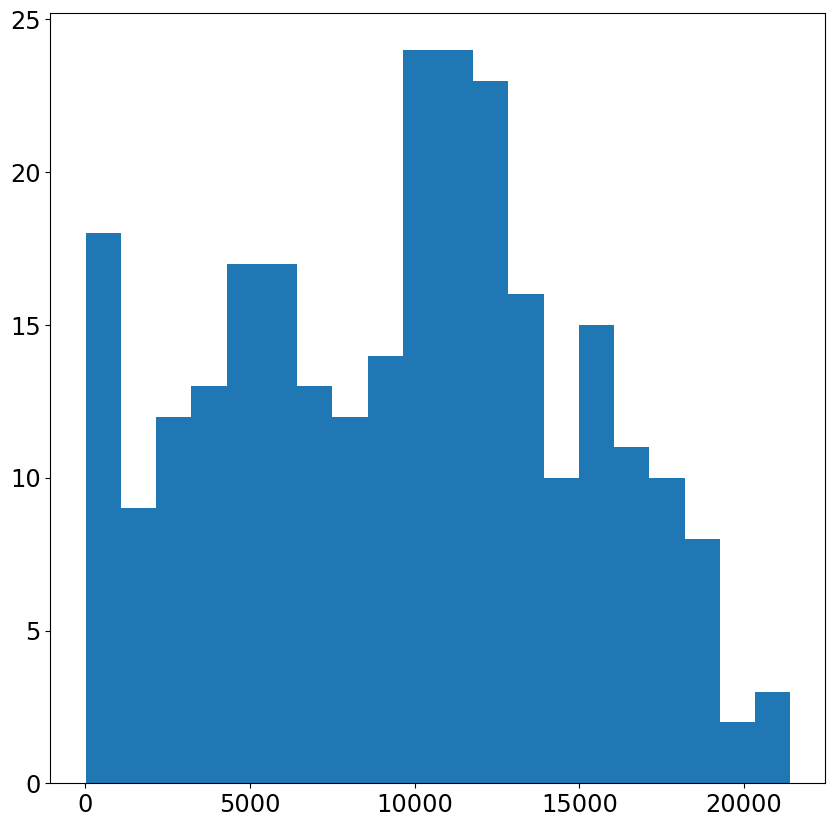

In [46]:
#histogram of AV volumes
plt.hist([sum(j.acv.grid_1d) for j in [i[0] for i in single_residue_info['Al488C5_AVs']]], bins=20)
plt.show()

In [47]:
#make sure that both residues in each pair are still in the single residue "good list"
for i in range(len(pair_residue_info)):
    if not (pair_residue_info['Residue Pair'][i][0] in single_residue_info[single_residue_info['Good List']]['Residue Index'].tolist()):
        pair_residue_info['Good List'][i] = False
        continue
    if not (pair_residue_info['Residue Pair'][i][1] in single_residue_info[single_residue_info['Good List']]['Residue Index'].tolist()):
        pair_residue_info['Good List'][i] = False
print('#Good={0}'.format(sum(single_residue_info['Good List'])))
print('#Good pairs={0}'.format(sum(pair_residue_info['Good List'])))

#Good=256
#Good pairs=15010


In [48]:
#do fret efficiency or distance metric calculations. Also calculate some additional metrics frettraj doesn't do by default
#only does the calculations as dye1-dye2:res1-res2 for now, but could incorporate directed calculations easily as all AVs calculated already
#can add option to only do attachment atom distances if FRET info not available or looking to do, say, DEER EPR

tempFRETs=[]
tempRmp_vec=[] #vectorial Rmp between AV clouds, calculated as RAV2-RAV1
tempRatt_vec=[] #same, but between attachment atoms

for i in range(len(pair_residue_info)):    
    if pair_residue_info['Good List'][i]==True:
        tempFRETs.append(ft.cloud.FRET.from_volumes(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0],single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[1])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0],list(settings['basic_dye_parameters']['Distance'].keys())[0],labels))    
        tempRmp_vec.append([k.acv.mp-j.acv.mp for j, k in zip(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0], single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0])])
        tempRatt_vec.append([k.av.attach_xyz-j.av.attach_xyz for j, k in zip(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0], single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0])])
    else:
        tempFRETs.append(None)  
        tempRmp_vec.append(None)  
        tempRatt_vec.append(None)  
pair_residue_info['{0}-{1}_FRET'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])]=tempFRETs
pair_residue_info['Rmp_vec']=tempRmp_vec
pair_residue_info['Ratt_vec']=tempRatt_vec
allEs=[]
allRDAs=[]
for i in tempFRETs:
    if i==None:
        allEs.append(None)
        allRDAs.append(None)
    else:
        allEs.append(ft.cloud.Trajectory(i, timestep=1).dataframe['<E_DA>'])
        allRDAs.append(ft.cloud.Trajectory(i, timestep=1).dataframe['<R_DA> (A)'])
pair_residue_info['AllEs']=allEs
pair_residue_info['AllRDAs']=allRDAs
del(tempFRETs)
del(tempRmp_vec)
del(tempRatt_vec)

Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |██

In [50]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,Rmp_vec,Ratt_vec,AllEs,AllRDAs
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",3.840744,None,None,None,None,None
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,None,None,None,None
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,None,None,None,None
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",4.036261,None,None,None,None,None
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",3.905426,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",3.370560,None,None,None,None,None
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",3.527306,None,None,None,None,None
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,None,None,None,None
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,None,None,None,None


In [52]:
#Now, add columns for the Rmp, R_DA, E, etc. and all the individual FRET eff params for distances corresponding to individual  states

dist_types=['mean_R_DA', 'sigma_R_DA', 'mean_E_DA', 'sigma_E_DA', 'mean_R_DA_E', 'sigma_R_DA_E', 'R_attach', 'R_mp']
#sigma is the std of the sampled distances WITHIN A GIVEN STATE FROM THAT STATES AV CLOUD
tempdists={i:[] for i in dist_types}

#these stds are the stds of the means amongst all states (how much the metric changes as conformation changes)
for i in dist_types:
    tempdists['std_'+i]=[]

for i in range(len(pair_residue_info)):
    if pair_residue_info['Good List'][i]==True:
        for j in dist_types:
            temp=[eval('i.{0}'.format(j)) for i in pair_residue_info['{0}-{1}_FRET'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])][i]]
            tempdists[j].append(temp)
            tempdists['std_'+j].append(np.std(temp))
    else:
        for j in dist_types:
            tempdists[j].append(None)
            tempdists['std_'+j].append(None)
            
for i in tempdists:
    pair_residue_info[i]=tempdists[i]
del(tempdists)

In [53]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,R_attach,R_mp,std_mean_R_DA,std_sigma_R_DA,std_mean_E_DA,std_sigma_E_DA,std_mean_R_DA_E,std_sigma_R_DA_E,std_R_attach,std_R_mp
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",3.840744,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",4.036261,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",3.905426,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",3.370560,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",3.527306,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#define some distance contrast metrics since what we're interested in isn't distances but contrast in dists
#between states

def Dynamic_Shift(E1, E2):
    return 2.**(-.5)*((1.-E1)**.5-(1.-E2)**.5)**2.

def Contrast_Fun(a, b, mode='Dynamic_Shift', scale=1.):
    if mode=='Dynamic_Shift':
        con=Dynamic_Shift(a,b)
    if mode=='Energy_Gaussian':
        con=gaussian(a-b, 0, scale)
    if mode=='Energy_InverseR':
        con=scale*abs(a-b)**-1.
    if mode=='Percent_Diff':
        con=abs(a-b)/(a+b)*2
    return con

In [55]:
#compute representative stats for changes in distance metrics
#will be used for ranking of sites in terms of "fret contrast"

contrast_types=['mean_R_DA', 'mean_E_DA', 'mean_R_DA_E', 'R_attach', 'R_mp']
custom_contrast=['Dynamic_Shift', 'Energy_InverseR', 'Energy_Gaussian'] #must be None, or some combo of 'Dynamic_Shift', 'Energy_InverseR', and 'Energy_Gaussian' in a list

tempcons={'d_'+i:[] for i in contrast_types}
#have to handle the dot product and dynamic shift bits separately
tempcons['d_Rmp_vec']=[]
tempcons['d_Ratt_vec']=[]
#dot product is absolute value as we just want to see ANY change in Rda wrt Rattach
tempcons['dRmpDOTdRatt']=[]
if custom_contrast is not None:
    for j in custom_contrast:
        tempcons[j]=[]

#this is the average of the contrast metric differences between frames
temp_avgdifs={'avg_d_'+i:[] for i in contrast_types}
temp_avgdifs['avg_dRmpDOTdRatt']=[]
if custom_contrast is not None:
    for j in custom_contrast:
        temp_avgdifs['avg_'+j]=[]

for i in range(len(pair_residue_info)):
    if pair_residue_info['Good List'][i]==True:
        for j in contrast_types:
            temp=[abs(l-k) for k, l in combinations(pair_residue_info[j][i], 2)]
            tempcons['d_'+j].append(temp)
            temp_avgdifs['avg_d_'+j].append(np.mean(temp))
        tempcons['d_Rmp_vec'].append([l-k for k, l in combinations(pair_residue_info['Rmp_vec'][i], 2)])
        tempcons['d_Ratt_vec'].append([l-k for k, l in combinations(pair_residue_info['Ratt_vec'][i], 2)])
        tempcons['dRmpDOTdRatt'].append([abs(np.sum(k*l))/(np.sum(k**2.)**.5)/(np.sum(l**2.)**.5) for k, l in zip(tempcons['d_Rmp_vec'][-1],tempcons['d_Ratt_vec'][-1])])
        #tempcons['dRmpDOTdRatt'].append([np.dot(k/(np.sum(k**2.)**.5), (l/np.sum(l**2.)**.5)) for k, l in zip(tempcons['d_Rmp_vec'][-1],tempcons['d_Ratt_vec'][-1])])
        temp_avgdifs['avg_dRmpDOTdRatt'].append(np.mean(tempcons['dRmpDOTdRatt'][-1]))
        if custom_contrast is not None:
            for m in custom_contrast:
                tempcons[m].append([Contrast_Fun(k, l, m, scale=1./len(pair_residue_info['mean_E_DA'][i])) for k, l in combinations(pair_residue_info['mean_E_DA'][i], 2)])
                temp_avgdifs['avg_'+m].append(np.mean(tempcons[m][-1]))    
        
    else:
        for j in contrast_types:
            tempcons['d_'+j].append(None)
            temp_avgdifs['avg_d_'+j].append(None)
        tempcons['d_Rmp_vec'].append(None)
        tempcons['d_Ratt_vec'].append(None)
        tempcons['dRmpDOTdRatt'].append(None)
        temp_avgdifs['avg_dRmpDOTdRatt'].append(None)
        if custom_contrast is not None:
            for m in custom_contrast:
                tempcons[m].append(None)
                temp_avgdifs['avg_'+m].append(None)    

for i in tempcons:
    pair_residue_info[i]=tempcons[i]
for i in temp_avgdifs:
    pair_residue_info[i]=temp_avgdifs[i]
        
del(tempcons)
del(temp_avgdifs)

In [56]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,Energy_Gaussian,avg_d_mean_R_DA,avg_d_mean_E_DA,avg_d_mean_R_DA_E,avg_d_R_attach,avg_d_R_mp,avg_dRmpDOTdRatt,avg_Dynamic_Shift,avg_Energy_InverseR,avg_Energy_Gaussian
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",3.840744,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",4.036261,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",3.905426,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",3.370560,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",3.527306,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",6.172748,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#introduce a sequence proximity penalty for sites to avoid sites too close together

proximity_penalty_scale=10.
pair_residue_info['Sequence Proximity Penalty']=[gaussian(i[0]-i[1], 0, proximity_penalty_scale, 'peakto1') for i in pair_residue_info['Residue Pair']]

In [58]:
#score function definitions
#just setting up some functions to be used in standardizing and ranking various other parameters

def std_0to1(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
def std_Zscore(data):
    return (data-np.mean(data))/np.std(data) #(x-u)/s
def square(data):
    return data**2.

def score_parameters(data, weights=None, param_mod=None, standardize_data='0to1', standardize_score='0to1'):
    #takes an input of a pd dataframe, outputs dataframe with same columns plus a summary score column
    #data=input columns, as array of dataframe
    #weights=optional weighting applied to each individual column in being added to the final score. must be same length as number of columns in data or None
    #standardize options for whether to standardize input columns and score column. Supports '0to1' (min=0, max=1), 'Zscore' (value is number of stds away from mean), None (use raw data/output)
    #param_mod should be either None or a list of length equal to the number of columns in data. List entries should be 'square' (square the data), 'abs' (absolute values of the data)
    score=np.zeros(len(data))

    
    
    if standardize_data=='0to1':
        for i in data:
            data[i]=std_0to1(data[i])
    elif standardize_data=='Zscore':
        for i in data:
            data[i]=std_Zscore(data[i])        
    
    if weights is not None:
        weights=pd.DataFrame(np.array(weights)[np.newaxis,:], columns=data.columns)
    else:
        weights=pd.DataFrame(np.ones((1,len(data.columns))),columns=data.columns)
    
    for i in data:
        score=score+weights[i][0]*data[i]
        
    data['Score']=score
    if standardize_score=='0to1':
        data['Score']=std_0to1(data['Score'])
    elif standardize_score=='Zscore':
        data['Score']=std_Zscore(data['Score'])
        
    return data

In [59]:
#Need a cleanup step, as calculations thus far haven't considered favorability of parameters. 
#here, parameters are rephrased in terms of high score=bad
#this is so the whole thing becomes a minimization problem
#example, low solvent accessibility is bad, so multiply by -1, before standardizing. now values near 0 initially are highest

pair_params_to_inverse=['avg_d_mean_R_DA', 'avg_d_mean_E_DA', 'avg_d_mean_R_DA_E', 'avg_d_R_attach', 'avg_d_R_mp', 'avg_dRmpDOTdRatt', 'avg_Dynamic_Shift', 'std_mean_R_DA', 'std_mean_E_DA', 'std_mean_R_DA_E', 'std_R_attach', 'std_R_mp', 'Mean Contacts', 'avg_Energy_InverseR', 'avg_Energy_Gaussian']
single_params_to_inverse=['Mean SASA (nm^2)']
for i in settings['basic_dye_parameters']['Position'].keys():
    single_params_to_inverse.append('avg_'+i+'_grid1dsum')
    
for i in pair_params_to_inverse:
    pair_residue_info[i]=-pair_residue_info[i]
for i in single_params_to_inverse:
    single_residue_info[i]=-single_residue_info[i]

In [60]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,avg_d_mean_R_DA,avg_d_mean_E_DA,avg_d_mean_R_DA_E,avg_d_R_attach,avg_d_R_mp,avg_dRmpDOTdRatt,avg_Dynamic_Shift,avg_Energy_InverseR,avg_Energy_Gaussian,Sequence Proximity Penalty
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",-3.840744,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995012
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980199
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955997
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",-4.036261,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923116
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",-3.905426,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",-3.370560,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980199
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",-3.527306,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955997
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995012
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980199


In [61]:
#calculate pair residue scores and individual residue scores
#should probably move to settings, these are effectively weights for the individual parameters that
#have will be standardized, multiplied by the weight, and added together
#also determines which parameters, in the end, are actually used

pair_parameters_to_score=['DCA Direct Info', 'Mean Contacts', 'avg_Dynamic_Shift', 'avg_dRmpDOTdRatt','Sequence Proximity Penalty']
pair_parameter_weights=[1., .2, 1., .3, 0.]
single_parameters_to_score=['Conservation Scores', 'Mean SASA (nm^2)','avg_'+list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']
single_parameter_weights=[.1, .1, .1]
pair_residue_info['Pair_Score']=score_parameters(pair_residue_info[pair_residue_info['Good List']==True][pair_parameters_to_score], weights=pair_parameter_weights, standardize_data='0to1')['Score']
single_residue_info['Single_Score']=score_parameters(single_residue_info[single_residue_info['Good List']==True][single_parameters_to_score], weights=single_parameter_weights, standardize_data='0to1')['Score']


In [65]:
pair_residue_info[pair_residue_info["Good List"] == True]

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,avg_d_mean_E_DA,avg_d_mean_R_DA_E,avg_d_R_attach,avg_d_R_mp,avg_dRmpDOTdRatt,avg_Dynamic_Shift,avg_Energy_InverseR,avg_Energy_Gaussian,Sequence Proximity Penalty,Pair_Score
102,"(1, 104)",True,0.000000,0.003969,0.680345,0.480676,0.680030,"[0.6803448796272278, 0.4806762933731079, 0.680...",-0.613684,[<fretraj.cloud.FRET object at 0x152b315d9df0>...,...,-0.066932,-2.325234,-2.000488,-2.968691,-0.951939,-0.003212,-14.704626,-1.164265,9.180138e-24,0.513206
103,"(1, 105)",True,0.000000,0.000421,0.869766,0.746645,0.821774,"[0.8697655200958252, 0.7466451525688171, 0.821...",-0.812728,[<fretraj.cloud.FRET object at 0x152b4d9d2160>...,...,-0.054754,-1.882878,-1.277391,-2.716512,-0.933114,-0.002122,-25.207600,-1.174305,3.261027e-24,0.510787
104,"(1, 106)",True,0.000000,0.000359,0.657299,0.602044,0.616153,"[0.6572988033294678, 0.6020441055297852, 0.616...",-0.625165,[<fretraj.cloud.FRET object at 0x152b4db79d90>...,...,-0.049164,-1.660754,-1.648152,-2.239181,-0.956049,-0.001518,-1341.160479,-1.177558,1.146877e-24,0.512758
105,"(1, 107)",True,0.000000,0.000303,0.377625,0.300442,0.308733,"[0.3776252269744873, 0.30044203996658325, 0.30...",-0.328933,[<fretraj.cloud.FRET object at 0x152b46459dc0>...,...,-0.075301,-2.549950,-1.578879,-3.598804,-0.969949,-0.002705,-5.028179,-1.162901,3.993337e-25,0.507972
106,"(1, 108)",True,0.000000,0.001364,0.549244,0.420153,0.499483,"[0.549244225025177, 0.42015302181243896, 0.499...",-0.489627,[<fretraj.cloud.FRET object at 0x152b4f4338b0>...,...,-0.091854,-3.123558,-1.567839,-3.945779,-0.937844,-0.004306,-4.160761,-1.146691,1.376615e-25,0.505009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22552,"(103, 267)",True,0.009071,0.000749,4.983152,5.274599,4.893319,"[4.983152389526367, 5.274598598480225, 4.89331...",-5.050357,[<fretraj.cloud.FRET object at 0x152b3338acd0>...,...,-0.024764,-3.423279,-1.204162,-3.318743,-0.960103,-0.003191,-14.983527,-1.193117,3.945282e-59,0.430951
22553,"(103, 268)",True,0.009345,0.000909,5.366975,5.472538,4.960384,"[5.366974830627441, 5.472537994384766, 4.96038...",-5.266632,[<fretraj.cloud.FRET object at 0x152b3338ad60>...,...,-0.035416,-3.441992,-1.494265,-3.073034,-0.957828,-0.004310,-11.211164,-1.189056,7.614890e-60,0.421823
22554,"(103, 269)",True,0.008616,0.000582,4.970502,5.121903,4.582648,"[4.970501899719238, 5.121902942657471, 4.58264...",-4.891684,[<fretraj.cloud.FRET object at 0x152b3338adf0>...,...,-0.035650,-2.464128,-1.803267,-2.033974,-0.976406,-0.002698,-10.698884,-1.189072,1.455145e-60,0.432824
22555,"(103, 270)",True,0.005166,0.000749,4.912739,4.919149,4.458623,"[4.912738800048828, 4.919149398803711, 4.45862...",-4.763504,[<fretraj.cloud.FRET object at 0x152b3338ae80>...,...,-0.055451,-3.084169,-2.283835,-3.239293,-0.964836,-0.005162,-8.740866,-1.176726,2.752998e-61,0.423400


(array([1.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 4.000e+00, 0.000e+00,
        6.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 1.500e+01, 8.000e+00,
        2.000e+01, 3.500e+01, 6.500e+01, 8.400e+01, 1.400e+02, 2.190e+02,
        3.150e+02, 5.040e+02, 7.220e+02, 9.970e+02, 1.493e+03, 2.306e+03,
        3.110e+03, 2.984e+03, 1.341e+03, 4.070e+02, 1.160e+02, 5.000e+01,
        1.700e+01, 7.000e+00, 8.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

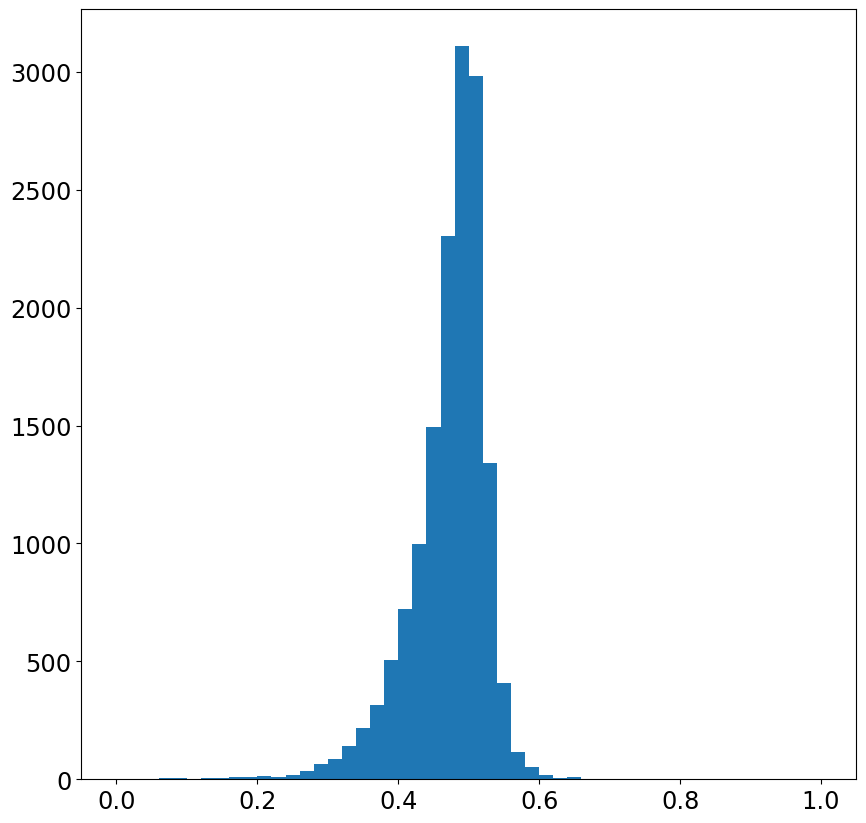

In [66]:
plt.hist(pair_residue_info['Pair_Score'], bins=50)

In [67]:
#calculate total score for each pair
#weights for relative contribution of single residue and pair residue information
pair_vs_single_weights=[1.,.5,.5]
Res1Score=[]
Res2Score=[]
for i in range(len(pair_residue_info)):
    Res1Score.append(single_residue_info[single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]]['Single_Score'].iloc[0])
    Res2Score.append(single_residue_info[single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]]['Single_Score'].iloc[0])

pair_residue_info['Residue 1 Score']=Res1Score
pair_residue_info['Residue 2 Score']=Res2Score
pair_residue_info['Total Score']=score_parameters(pair_residue_info[pair_residue_info['Good List']==True][['Pair_Score', 'Residue 1 Score', 'Residue 2 Score']], weights=pair_vs_single_weights, standardize_score='0to1')['Score']


In [68]:
#an additional function used for selecting pairs. Essentially allows favoring coincidence of one of two residues
#in two different fret pairs (good for logistics of labeling, minimizing distinct perturbations to samples
#with different fret pairs), but disfavoring nearby pairs (otherwise, redundant information from FRET pairs)

def CoProximity_Penalty(Pair1, Pair2, width, coincidence_boon=1., norm='peakto1'):
    penalty=0.
    difs=[i-j for i, j in zip(Pair1, Pair2)]
    if difs==[0 for i in difs]:
        penalty+=np.inf
    for i in difs:
        if i==0:
            penalty-=coincidence_boon*gaussian(0,0,width,norm)
        else:
            penalty+=gaussian(i, 0, width, norm)
    return penalty

In [69]:
#do selection of top X complementary FRET pairs via forward greedy approach. Select best scorer first, then add additional ones until X pairs added
#so top pair is the "seed" and additional ones added greedily
#also some weights (coincidence_boon, comproximity width and penalty fun, dot product, etc) provided
#dot prod used to increase orthogonality between selected pairs
#will instead implement dot product of vectorized contrast metrics (less physical orthogonality, more
#orthogonality in observed FRET values under the relevant structural changes)
ranked_candidates=pair_residue_info[pair_residue_info['Good List']].sort_values('Total Score')

Num_Pairs=10
CoProximity_Penalty_Width=20. #penalty for two sites in complementary pairs being near each other, but non-identical (shared nodes are good, but not neighboring nodes)
#for the following functions, max and min judge based on each pairs worst/best performance respectively, mean and sum based on average performance
CoProximity_Penalty_fun=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used to penalize the complentarity score based Co-Proximity of labeling sites
Coincidence_Boon=.1
dot_prod_penalty_fun=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used to penalize the complentarity score based on alignment of Rmp vectors
dot_prod_among_states=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used as the dot product between pairs amongst the dot products calculated for each state 
CoProximityWeight=1. #weight applied to CoProximity
DotProdWeight=1.


CompscoreMethod=lambda x, y: np.add(x,y) #should be either sum or multiply. Should be sum because otherwise negatives get funky

ScoreMethod=lambda x, y: np.add(x,y) #should be either sum (add score and compscore together, in which case ScoreWeight matters) or multiply (in which case compscore is a modifier to the original score, and weight doesnt matter. negatives fine if Total Score set to 0to1)
ScoreWeight=2. #weight applied to the score


keep_list=[]
keep_list.append(ranked_candidates.iloc[0])
while len(keep_list)<Num_Pairs:
    best=(None, np.inf) #best additional pair based on the criteria tested for complementarity
    for j in range(len(ranked_candidates)):
        #no repeat pairs allowed
        if ranked_candidates['Residue Pair'].iloc[j] in [k['Residue Pair'] for k in keep_list]:
            continue
        compscore=1.
        #applies penalty based on co-incidence of labeling sites in-exactly with ones already in the list
        compscore=CompscoreMethod(compscore, CoProximityWeight*CoProximity_Penalty_fun([CoProximity_Penalty(ranked_candidates['Residue Pair'].iloc[j], k['Residue Pair'], CoProximity_Penalty_Width, coincidence_boon=Coincidence_Boon) for k in keep_list]))
        #normalized dot product calculations of candidate pair against all other pairs, and for all states
        compscore=CompscoreMethod(compscore, DotProdWeight*dot_prod_penalty_fun([dot_prod_among_states([np.sum(m[0]*m[1])*sum(m[0]**2.)**(-.5)*sum(m[1]**2.)**(-.5) for m in l]) for l in [zip(ranked_candidates['Rmp_vec'].iloc[j], k['Rmp_vec']) for k in keep_list]]))
        #incorporate in the pair's score itself, either additively or multiplicatively
        compscore=ScoreMethod(compscore, ScoreWeight*ranked_candidates['Total Score'].iloc[j])
        
        if compscore<best[1]:
            best=(j, compscore)
            
    keep_list.append(ranked_candidates.iloc[best[0]])
    
Final_Network=pd.concat(keep_list, axis=1).T

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

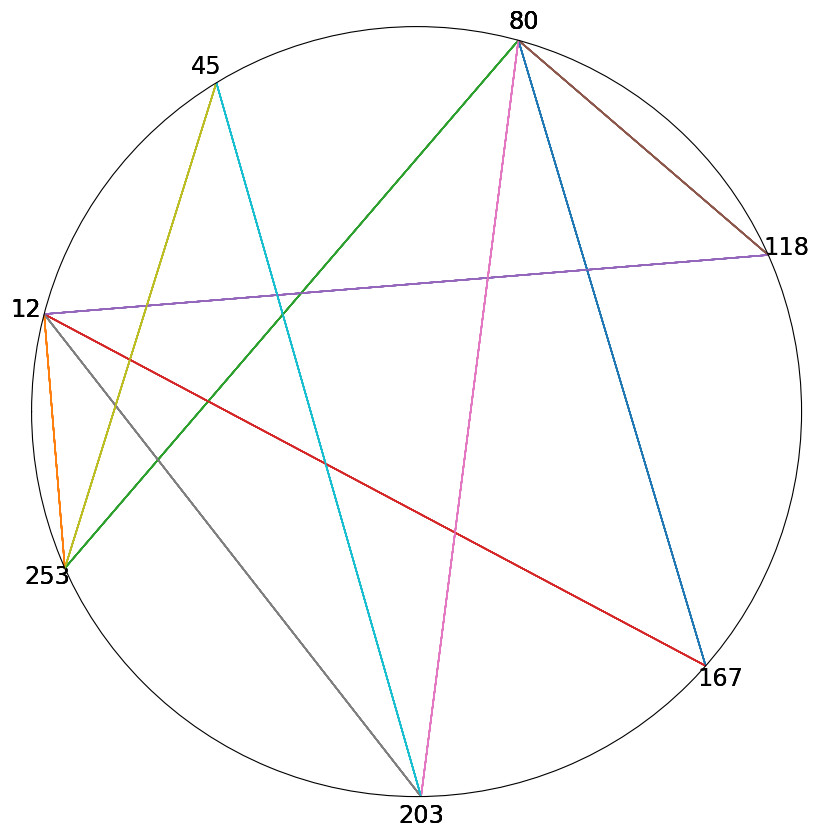

In [43]:
#plot the selected FRET pairs on a radial plot

ax=plt.subplot(111,projection='polar')
firstres=single_residue_info['Residue Index'].iloc[0]
lastres=single_residue_info['Residue Index'].iloc[-1]
pairlist=np.array([[i[0],i[1]] for i in Final_Network['Residue Pair']]).astype(float).T
for i in Final_Network['Residue Pair']:
    ax.plot((pairlist-firstres)/(lastres-firstres)*2*np.pi,[1,1])
ax.set_rmax(1)
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_rticks([])
plt.grid(visible=None)
plt.thetagrids((pairlist.flatten()-firstres)/(lastres-firstres)*360, labels=pairlist.flatten().astype(int))
plt.savefig('Network.png')

plt.show()

In [44]:
#save the top FRET pairs that were selected
To_Save_List=Final_Network[['Residue Pair', 'DCA Direct Info', 'avg_Dynamic_Shift', 'Pair_Score', 'Residue 1 Score', 'Residue 2 Score', 'Total Score','AllEs','AllRDAs']]
To_Save_List.to_csv('Pair_List.csv', index=False)

Text(0.5, 0, 'Index')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

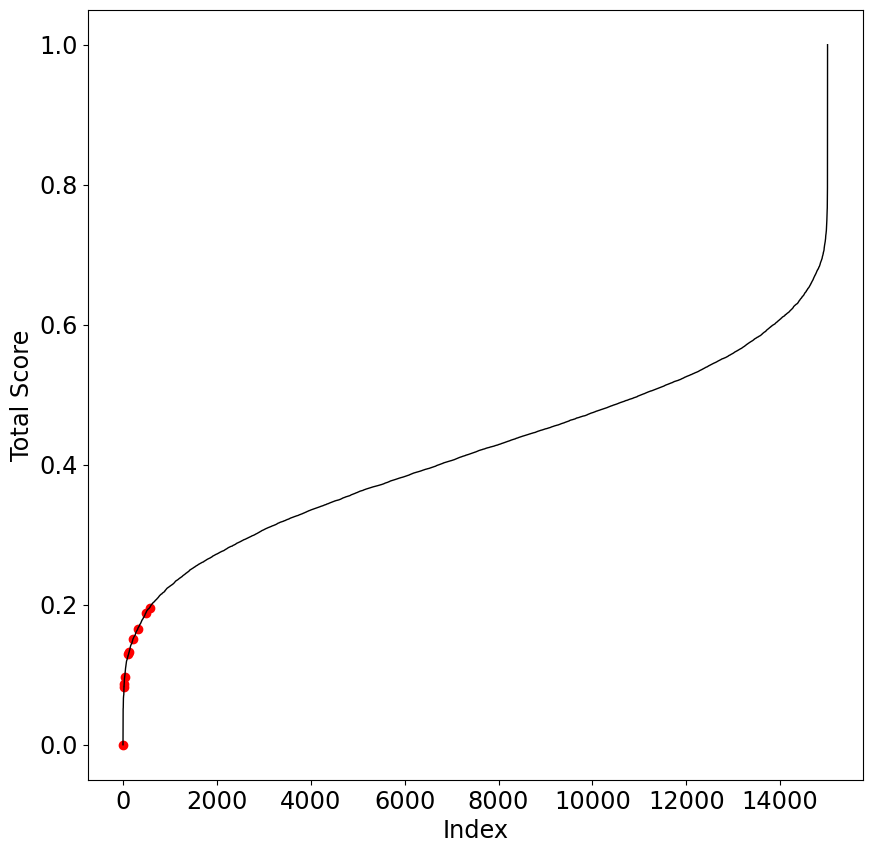

In [45]:
#plot the scores of selected pairs. Should see them appear near the min, but distribution will change sample-to-sample

plt.plot(np.arange(len(pair_residue_info['Total Score'][pair_residue_info['Total Score'].notna()])),pair_residue_info['Total Score'][pair_residue_info['Total Score'].notna()].sort_values(), color='black', linewidth=1)

indices=[]
for i in Final_Network['Residue Pair']:
    indices.append((pair_residue_info[pair_residue_info['Total Score'].notna()].sort_values('Total Score')['Residue Pair']).tolist().index(i))
plt.scatter(indices, Final_Network['Total Score'], color='red')


plt.ylabel('Total Score')
plt.xlabel('Index')

In [46]:
Final_Network

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,avg_d_R_mp,avg_dRmpDOTdRatt,avg_Dynamic_Shift,avg_Energy_InverseR,avg_Energy_Gaussian,Sequence Proximity Penalty,Pair_Score,Residue 1 Score,Residue 2 Score,Total Score
18335,"(80, 167)",True,0.078082,0.008,3.618985,3.342546,2.772807,"[3.618985414505005, 3.342545509338379, 2.77280...",-3.244779,[<fretraj.cloud.FRET object at 0x150d21e2a100>...,...,-10.936102,-0.994357,-0.031179,-3.514401,-0.944619,0.0,0.307233,0.086539,0.137885,0.0
3155,"(12, 253)",True,0.085711,0.005065,0.776147,0.835658,0.806825,"[0.7761465907096863, 0.8356581926345825, 0.806...",-0.80621,[<fretraj.cloud.FRET object at 0x150d267f6d30>...,...,-1.365026,-0.996538,-0.000532,-11.278967,-1.190304,0.0,0.519453,0.237696,0.116422,0.195935
18421,"(80, 253)",True,0.041209,0.004277,1.79183,1.951778,1.81555,"[1.7918301820755005, 1.951777696609497, 1.8155...",-1.853053,[<fretraj.cloud.FRET object at 0x150d21d12130>...,...,-0.739171,-0.999593,-0.000132,-51.574292,-1.196333,0.0,0.502083,0.086539,0.116422,0.129229
3069,"(12, 167)",True,0.182371,0.009509,3.815336,4.123183,3.182514,"[3.815335988998413, 4.123182773590088, 3.18251...",-3.707011,[<fretraj.cloud.FRET object at 0x150d2225afa0>...,...,-11.876694,-0.960217,-0.021365,-4.060553,-1.145623,0.0,0.367798,0.237696,0.137885,0.097032
3020,"(12, 118)",True,0.092225,0.007251,3.368624,3.745947,3.095688,"[3.368624210357666, 3.7459471225738525, 3.0956...",-3.40342,[<fretraj.cloud.FRET object at 0x150d220295e0>...,...,-3.958371,-0.975087,-0.004298,-5.480071,-1.149309,0.0,0.464518,0.237696,0.100219,0.151648
18286,"(80, 118)",True,0.04801,0.004342,1.110691,1.084631,1.142373,"[1.1106905937194824, 1.0846314430236816, 1.142...",-1.112565,[<fretraj.cloud.FRET object at 0x150d21e01820>...,...,-1.324722,-0.996138,-0.000065,-25.80717,-1.195387,0.000732,0.515421,0.086539,0.100219,0.132876
18371,"(80, 203)",True,0.079787,0.005285,1.098554,1.136538,1.228021,"[1.0985535383224487, 1.136538028717041, 1.2280...",-1.154371,[<fretraj.cloud.FRET object at 0x150d21e3f5e0>...,...,-10.529257,-0.998883,-0.013447,-4.751541,-0.970969,0.0,0.437918,0.086539,0.125382,0.087341
3105,"(12, 203)",True,0.181422,0.006953,0.860946,0.753637,0.709834,"[0.8609459400177002, 0.7536367774009705, 0.709...",-0.774806,[<fretraj.cloud.FRET object at 0x150d222773a0>...,...,-5.874599,-0.995988,-0.009533,-7.64632,-1.149258,0.0,0.471954,0.237696,0.125382,0.165747
11141,"(45, 253)",True,0.063908,0.007414,2.752014,2.697419,2.344526,"[2.75201416015625, 2.6974191665649414, 2.34452...",-2.597986,[<fretraj.cloud.FRET object at 0x150d23691370>...,...,-0.500693,-0.999633,-0.000035,-49.603499,-1.19643,0.0,0.498465,0.256961,0.116422,0.188146
11091,"(45, 203)",True,0.093266,0.006631,2.677876,2.667529,2.76986,"[2.6778762340545654, 2.6675291061401367, 2.769...",-2.705088,[<fretraj.cloud.FRET object at 0x150d236bc700>...,...,-11.189697,-0.997052,-0.02568,-1.817561,-0.980146,0.0,0.344394,0.256961,0.125382,0.083136


In [47]:
pair_residue_info

,Residue Pair,Good List,DCA Mutual Info,DCA Direct Info,Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_closed_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_open_fromSBM+DCA.pdb (nm),Contacts /zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs/RBP_Twisted_allatom.pdb (nm),Contacts,Mean Contacts,Al488C5-Al647C2_FRET,...,avg_d_R_mp,avg_dRmpDOTdRatt,avg_Dynamic_Shift,avg_Energy_InverseR,avg_Energy_Gaussian,Sequence Proximity Penalty,Pair_Score,Residue 1 Score,Residue 2 Score,Total Score
0,"(1, 2)",False,0.000000,0.053536,3.740076,4.434337,3.347819,"[3.7400760650634766, 4.434337139129639, 3.3478...",-3.840744,None,...,NaN,NaN,NaN,NaN,NaN,0.995012,NaN,0.280443,0.649865,NaN
1,"(1, 3)",False,0.000000,0.028687,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,0.980199,NaN,0.280443,0.829620,NaN
2,"(1, 4)",False,0.000000,0.013261,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,0.955997,NaN,0.280443,0.973442,NaN
3,"(1, 5)",False,0.000000,0.005106,3.917968,4.650023,3.540791,"[3.9179680347442627, 4.650022983551025, 3.5407...",-4.036261,None,...,NaN,NaN,NaN,NaN,NaN,0.923116,NaN,0.280443,0.968396,NaN
4,"(1, 6)",False,0.000000,0.003006,3.816537,4.365122,3.534618,"[3.8165371417999268, 4.365121841430664, 3.5346...",-3.905426,None,...,NaN,NaN,NaN,NaN,NaN,0.882497,NaN,0.280443,0.952917,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36580,"(268, 270)",False,0.011128,0.056440,3.231394,3.882882,2.997405,"[3.231394052505493, 3.8828818798065186, 2.9974...",-3.370560,None,...,NaN,NaN,NaN,NaN,NaN,0.980199,NaN,0.892694,0.554530,NaN
36581,"(268, 271)",False,0.002085,0.032441,3.432003,4.116376,3.033539,"[3.4320027828216553, 4.116375923156738, 3.0335...",-3.527306,None,...,NaN,NaN,NaN,NaN,NaN,0.955997,NaN,0.892694,0.410789,NaN
36582,"(269, 270)",False,0.012332,0.083140,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,0.995012,NaN,0.771496,0.554530,NaN
36583,"(269, 271)",False,0.002435,0.045029,6.172748,6.172748,6.172748,"[6.17274808883667, 6.17274808883667, 6.1727480...",-6.172748,None,...,NaN,NaN,NaN,NaN,NaN,0.980199,NaN,0.771496,0.410789,NaN


In [48]:
pair_residue_info.to_csv('all_pair_info.csv')
single_residue_info.to_csv('all_single_info.csv')